# Counting results

In [17]:
import pandas as pd
from matplotlib_venn import venn3
from matplotlib import pyplot as plt

## Table in appendix

In [18]:
journals = pd.read_csv("../data/processed/journals_deduplicated.csv")
journals.head()

,title,wikidataURL,ISSN-L,openAlexID,IPNIpubID,ZooBankPubID,dissolvedYear,dissolved,source
0,Muelleria,http://www.wikidata.org/entity/Q11693922,0077-1813,S4306520314,1554-2,NaN,NaN,NaN,Wikidata taxonomic subject
1,The Auk,http://www.wikidata.org/entity/Q2300649,0004-8038,S152904045,NaN,3F3F951F-B494-44B0-B286-AF9BCB097966,NaN,NaN,Wikidata taxonomic subject
2,Nuytsia,http://www.wikidata.org/entity/Q2005798,0085-4417,S103214341,1029-2,NaN,NaN,NaN,Wikidata taxonomic subject
3,Kew Bulletin,http://www.wikidata.org/entity/Q2675794,0075-5974,S157974409,987-2,NaN,NaN,NaN,Wikidata taxonomic subject
4,Willdenowia,http://www.wikidata.org/entity/Q2675951,0511-9618,S107729305,3087-2,NaN,NaN,NaN,Wikidata taxonomic subject


In [19]:
#table = pd.DataFrame({"name":["Taxonomic journals with title",
#                             "Journals with Wikidata ID",
#                             "Journals with ISSN-L",
#                             "Journals with IPNI Publication ID in Wikidata",
#                             "Journals with ZooBank Publication ID in Wikidata",
#                             "Journals with OpenAlex ID"
#                            # union of OpenAlex ID and IPNI etc
#                             ],
#                      "value":[0,0,0,0,0,0]})
#
#table["value"] = table["value"].astype(str)  # Convert the column to string type
#
#table.loc[0,"value"] = str(len([x for x in journals["title"] if x == x]))

#for i, column in enumerate(journals.columns[1:6]):
#    table.loc[i+1, "value"] = str(len([x for x in journals[column] if x == x]))

#table = table.set_index("name")
#table # ctrl + click to select cells to copy

## 1. Journals

Taxonomic journals:
- with title
- found on wikidata (each method)
- found on OpenAlex
- total
- still publishing in the last 10 years
- dissolved (confirmed)
- with ISSN-L
- with IPNI publication ID
- with ZooBank publication ID
- with OpenAlex ID

In [20]:
print("Number of journals: " + str(len(journals)))
print("Number of journals with known title: "+\
      str(len([x for x in journals["title"] if x == x])))

Number of journals: 2686
Number of journals with known title: 2686


In [21]:
for column in journals.columns[1:6]:
    print(f"Number of journals with {column}: {journals[column].notna().sum()}")

Number of journals with wikidataURL: 2631
Number of journals with ISSN-L: 2001
Number of journals with openAlexID: 1103
Number of journals with IPNIpubID: 1821
Number of journals with ZooBankPubID: 867


In [22]:
print("Journals that were dissolved (confirmed): ")
journals["dissolved"].value_counts()

Journals that were dissolved (confirmed): 


dissolved
True     644
False    157
Name: count, dtype: int64

In [23]:
# Filter journals with no OpenAlexID and not dissolved
filtered_data = journals[journals["openAlexID"].isna() & journals["dissolvedYear"].isna()]

# Take a random sample of 100 rows (all columns)
sample = filtered_data.sample(n=100, random_state=42)  # Adjust 'n' for sample size

# Output the sample
print(sample)

# Optionally, save the sample to a file
sample.to_csv("sample_journals.csv", index=False)

# Count the total
total_count = filtered_data.shape[0]  # Number of rows in the filtered data

# Print the total count
print(f"Total journals with no OpenAlexID and not dissolved: {total_count}")


                                                  title  \
2293  Rozprawy i Sprawozdania z Posiedzen Wydzialu M...   
2003        Abhandlungen der Geologischen Bundesanstalt   
422   Archivio Botanico per la Sistematica, Fitogeog...   
1778                Berlinisches Jahrbuch der Pharmacie   
2438             Memorias del Museo de Historia Natural   
...                                                 ...   
2270                   Zeitschrift für Sukkulentenkunde   
974      Anales del Instituto Botánico A. J. Cavanilles   
1869                                         Strelitzia   
861   Bollettino del Museo Regionale di Scienze Natu...   
1090                               Tạp chí Sinh Vật Học   

                                    wikidataURL     ISSN-L openAlexID  \
2293   http://www.wikidata.org/entity/Q96774686  2081-1896        NaN   
2003   http://www.wikidata.org/entity/Q13548386        NaN        NaN   
422    http://www.wikidata.org/entity/Q16488670  1721-1670        NaN   

In [25]:
articles = pd.read_pickle("../data/interim/keyword-filtered_articles/filtered_articles.pkl")
articles.head()

,Index,id,doi,title,display_name,publication_year,publication_date,ids,language,primary_location,...,source_is_core,source_host_organization,source_host_organization_name,source_host_organization_lineage,source_host_organization_lineage_names,source_type,oa_is_oa,oa_oa_status,oa_oa_url,oa_any_repository_has_fulltext
0,0,https://openalex.org/W2766208183,https://doi.org/10.1371/journal.pone.0185809,More than 75 percent decline over 27 years in ...,More than 75 percent decline over 27 years in ...,2017,2017-10-18,{'openalex': 'https://openalex.org/W2766208183...,en,"{'is_oa': True, 'landing_page_url': 'https://d...",...,True,https://openalex.org/P4310315706,Public Library of Science,[https://openalex.org/P4310315706],[Public Library of Science],journal,True,gold,https://journals.plos.org/plosone/article/file...,True
1,2,https://openalex.org/W2130560194,https://doi.org/10.1371/journal.pone.0105992,SoilGrids1km — Global Soil Information Based o...,SoilGrids1km — Global Soil Information Based o...,2014,2014-08-29,{'openalex': 'https://openalex.org/W2130560194...,en,"{'is_oa': True, 'landing_page_url': 'https://d...",...,True,https://openalex.org/P4310315706,Public Library of Science,[https://openalex.org/P4310315706],[Public Library of Science],journal,True,gold,https://journals.plos.org/plosone/article/file...,True
2,3,https://openalex.org/W2155544089,https://doi.org/10.1371/journal.pone.0125814,Mapping Soil Properties of Africa at 250 m Res...,Mapping Soil Properties of Africa at 250 m Res...,2015,2015-06-25,{'openalex': 'https://openalex.org/W2155544089...,en,"{'is_oa': True, 'landing_page_url': 'https://d...",...,True,https://openalex.org/P4310315706,Public Library of Science,[https://openalex.org/P4310315706],[Public Library of Science],journal,True,gold,https://journals.plos.org/plosone/article/file...,True
3,4,https://openalex.org/W1551951435,https://doi.org/10.1371/journal.pone.0130324,Can DNA-Based Ecosystem Assessments Quantify S...,Can DNA-Based Ecosystem Assessments Quantify S...,2015,2015-07-08,{'openalex': 'https://openalex.org/W1551951435...,en,"{'is_oa': True, 'landing_page_url': 'https://d...",...,True,https://openalex.org/P4310315706,Public Library of Science,[https://openalex.org/P4310315706],[Public Library of Science],journal,True,gold,https://journals.plos.org/plosone/article/file...,True
4,5,https://openalex.org/W2005951061,https://doi.org/10.1371/journal.pone.0119248,A Higher Level Classification of All Living Or...,A Higher Level Classification of All Living Or...,2015,2015-04-29,{'openalex': 'https://openalex.org/W2005951061...,en,"{'is_oa': True, 'landing_page_url': 'https://d...",...,True,https://openalex.org/P4310315706,Public Library of Science,[https://openalex.org/P4310315706],[Public Library of Science],journal,True,gold,https://journals.plos.org/plosone/article/file...,True


In [26]:
print("Number of journals that contained relevant (i.e. taxonomic) articles: " + \
      str(len(set(articles["source_id"]))))

Number of journals that contained relevant (i.e. taxonomic) articles: 474


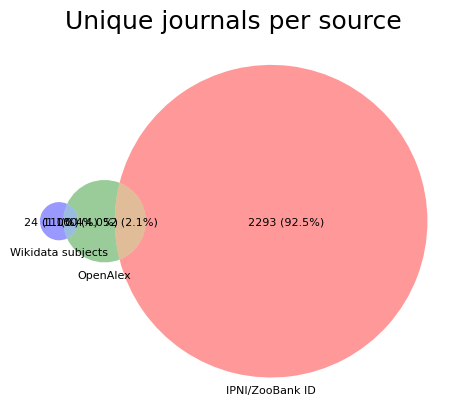

In [27]:
# Define sets
ipnizoo = set(journals[journals["source"] == "IPNI or ZooBank ID"]["title"])
openalex = set(journals[journals["source"] == "OpenAlex taxonomy concept"]["title"])
wikisubjects = set(journals[journals["source"] == "Wikidata taxonomic subject"]["title"])

# Total unique journals for percentage calculation
total_journals = len(ipnizoo | openalex | wikisubjects)

# Venn diagram
venn = venn3([ipnizoo, openalex, wikisubjects], ("IPNI/ZooBank ID", "OpenAlex", "Wikidata subjects"))

# Adjust subset label font sizes (numbers inside the diagram)
for label in venn.subset_labels:
    if label:  # Only adjust non-empty labels
        label.set_fontsize(8)  # Set font size (adjust value as needed)

# Adjust set label font sizes (labels for the circles)
for label in venn.set_labels:
    if label:  # Only adjust non-empty labels
        label.set_fontsize(8)  # Set font size (adjust value as needed)
# Annotate each section with count and percentage

for idx, label in enumerate(venn.subset_labels):
    if label:  # Only annotate non-empty regions
        count = int(label.get_text())  # Convert count to integer
        percentage = (count / total_journals) * 100
        label.set_text(f"{count} ({percentage:.1f}%)")

# Add title
plt.title("Unique journals per source", fontsize=18)

# Display plot
plt.show()

## 2. Articles

- total number
- number with at least one European author

In [28]:
print("Number of articles related to taxonomy with at least one European author: " +\
      str(len(set(articles["id"]))))

Number of articles related to taxonomy with at least one European author: 33499


## 3. Authors

In [29]:
authors = pd.read_csv("../data/processed/country_taxonomic_authors_no_duplicates.tsv", sep="\t",low_memory=False)

In [30]:
print("Number of European authors before disambiguation: "+\
      str(len(authors)))

Number of European authors before disambiguation: 31839


In [31]:
disamb_authors = pd.read_pickle("../data/processed/authors_disambiguated_truncated.pkl")

In [32]:
print("Number of European authors after disambiguation: "+\
      str(len(disamb_authors)))

Number of European authors after disambiguation: 31521


In [33]:
print("Number of European institutions publishing taxonomic articles: "+\
      str(len(set(disamb_authors["inst_id"]))))

Number of European institutions publishing taxonomic articles: 2925


In [34]:
len(set(authors[authors["inst_country_code"]=="BE"]["inst_display_name"]))

60

In [35]:
authors.columns

Index(['Index', 'article_id', 'author_position', 'author', 'institutions',
       'countries', 'is_corresponding', 'raw_author_name',
       'raw_affiliation_strings', 'affiliations',
       ...
       'source_host_organization_name', 'source_host_organization_lineage',
       'source_host_organization_lineage_names', 'source_type', 'oa_is_oa',
       'oa_oa_status', 'oa_oa_url', 'oa_any_repository_has_fulltext',
       'abstract_full_text', 'species_subject'],
      dtype='object', length=103)

## 4. Taxonomy

Total number of families within Plantae:
Total number of families within Animalia:
Total number of families within Fungi:
Total number of families within Protists:
…. See similar figure here: https://data-blog.gbif.org/post/gbif-backbone-taxonomy/

In [36]:
# supply and demand order save?
authors_tree = pd.read_pickle("../data/processed/authors_disambiguated_truncated.pkl")

In [37]:
authors2 = pd.read_pickle("../data/interim/country_taxonomic_authors_no_duplicates.pkl")

In [38]:
authors2.head()

,Index,article_id,author_position,author,institutions,countries,is_corresponding,raw_author_name,raw_affiliation_strings,affiliations,...,source_host_organization_name,source_host_organization_lineage,source_host_organization_lineage_names,source_type,oa_is_oa,oa_oa_status,oa_oa_url,oa_any_repository_has_fulltext,abstract_full_text,species_subject
0,138564,https://openalex.org/W2949636722,last,"{'id': 'https://openalex.org/A5061238929', 'di...","[{'id': 'https://openalex.org/I241749', 'displ...",[GB],False,Chris D. Jiggins,"[Department of Zoology, University of Cambridg...",[{'raw_affiliation_string': 'Department of Zoo...,...,Public Library of Science,[https://openalex.org/P4310315706],[Public Library of Science],journal,True,gold,https://journals.plos.org/plosbiology/article/...,True,The evolution of new species is made easier wh...,"[Heliconius timareta, Heliconius cydno, Helico..."
1,54150,https://openalex.org/W4388774616,middle,"{'id': 'https://openalex.org/A5020637267', 'di...","[{'id': 'https://openalex.org/I4068193', 'disp...",[RS],False,Mirko Šević,"[University of Belgrade – Faculty of Biology, ...",[{'raw_affiliation_string': 'University of Bel...,...,Consortium of European Natural History Museums,[https://openalex.org/P4310311153],[Consortium of European Natural History Museums],journal,True,diamond,https://europeanjournaloftaxonomy.eu/index.php...,True,The present paper is devoted to the descriptio...,"[Acanthophorella barjadzei, Trachysphaera corc..."
2,62918,https://openalex.org/W4285210299,middle,"{'id': 'https://openalex.org/A5060831119', 'di...","[{'id': 'https://openalex.org/I161929037', 'di...",[FR],False,M. Coton,"[Univ Brest, Laboratoire Universitaire de Biod...","[{'raw_affiliation_string': 'Univ Brest, Labor...",...,Ingenta,[https://openalex.org/P4310311675],[Ingenta],journal,True,green,https://digital.csic.es/bitstream/10261/303778...,True,Seven,"[Penicillium roqueforti, Yamadazyma barbieri, ..."
3,76576,https://openalex.org/W4382401868,first,"{'id': 'https://openalex.org/A5032522211', 'di...","[{'id': 'https://openalex.org/I4210141221', 'd...",[ES],False,Pedro Díaz Jiménez,[Jardín Botánico “Araceario Thomas B. Croat” T...,[{'raw_affiliation_string': 'Jardín Botánico “...,...,Wiley,[https://openalex.org/P4310320595],[Wiley],journal,False,closed,None,False,During fieldwork conducted in 2022 in Llano de...,"[Spathiphyllum frailescanense, Anthurium knopf..."
4,79768,https://openalex.org/W2951469827,middle,"{'id': 'https://openalex.org/A5024626912', 'di...","[{'id': 'https://openalex.org/I106118109', 'di...",[HU],False,Dániel Botka,"[Department of Palaeontology, Eötvös Loránd Un...",[{'raw_affiliation_string': 'Department of Pal...,...,Springer Nature,[https://openalex.org/P4310319965],[Springer Nature],journal,True,hybrid,https://link.springer.com/content/pdf/10.1007/...,False,We establish a neotype in the collection of th...,[]


In [39]:
authors_tree.head()

,author_id,author_display_name,author_orcid,inst_id,inst_display_name,species_subject,truncatedName,strippedName,order,kingdom
0,https://openalex.org/A5061238929,Chris D. Jiggins,https://orcid.org/0000-0002-7809-062X,https://openalex.org/I241749,University of Cambridge,"[Heliconius timareta, Heliconius cydno, Helico...",C Jiggins,ChrisDJiggins,[Lepidoptera],[Animalia]
1,https://openalex.org/A5020637267,Mirko Šević,https://orcid.org/0000-0002-1979-9516,https://openalex.org/I4068193,University of Belgrade,"[Acanthophorella barjadzei, Trachysphaera corc...",M Šević,MirkoŠević,"[Chordeumatida, Glomerida]",[Animalia]
2,https://openalex.org/A5060831119,Monika Coton,https://orcid.org/0000-0002-0148-6802,https://openalex.org/I161929037,Université de Bretagne Occidentale,"[Penicillium roqueforti, Yamadazyma barbieri, ...",M Coton,MonikaCoton,"[Eurotiales, Saccharomycetales]",[Fungi]
3,https://openalex.org/A5032522211,Pedro Jiménez,https://orcid.org/0000-0003-2079-674X,https://openalex.org/I4210141221,Real Jardín Botánico,"[Spathiphyllum frailescanense, Anthurium knopf...",P Jiménez,PedroJiménez,[Alismatales],[Plantae]
4,https://openalex.org/A5024626912,Dániel Botka,https://orcid.org/0000-0002-6627-4640,https://openalex.org/I106118109,Eötvös Loránd University,[],D Botka,DánielBotka,[],[]


In [40]:
# 3. Count how many authors study each kingdom:
num_plantae = sum("Plantae" in k for k in authors_tree["kingdom"])
num_animalia = sum("Animalia" in k for k in authors_tree["kingdom"])
num_fungi    = sum("Fungi" in k for k in authors_tree["kingdom"])


In [41]:
# Calculate total authors
total_authors = len(authors_tree)

# Get percentages
pct_plantae = 100.0 * num_plantae / total_authors
pct_animalia = 100.0 * num_animalia / total_authors
pct_fungi = 100.0 * num_fungi / total_authors

print(f"Number of authors studying Plantae:  {num_plantae} ({pct_plantae:.1f}%)")
print(f"Number of authors studying Animalia: {num_animalia} ({pct_animalia:.1f}%)")
print(f"Number of authors studying Fungi:    {num_fungi} ({pct_fungi:.1f}%)")

Number of authors studying Plantae:  6844 (21.7%)
Number of authors studying Animalia: 10707 (34.0%)
Number of authors studying Fungi:    2253 (7.1%)


In [42]:
# 2. Filter authors who have at least one kingdom (non-empty list)
authors_with_kingdom = authors_tree[authors_tree["kingdom"].apply(lambda x: len(x) > 0)]

# 3. Count how many of those authors study each kingdom
num_plantae = sum("Plantae" in k for k in authors_with_kingdom["kingdom"])
num_animalia = sum("Animalia" in k for k in authors_with_kingdom["kingdom"])
num_fungi = sum("Fungi" in k for k in authors_with_kingdom["kingdom"])

# 4. Calculate percentages among authors *with* a kingdom
total_with_kingdom = len(authors_with_kingdom)

pct_plantae = 100.0 * num_plantae / total_with_kingdom
pct_animalia = 100.0 * num_animalia / total_with_kingdom
pct_fungi = 100.0 * num_fungi / total_with_kingdom

# 5. Print or store the results
print(f"Number of authors with at least one kingdom: {total_with_kingdom}")
print(f"Plantae:  {num_plantae} ({pct_plantae:.2f}%)")
print(f"Animalia: {num_animalia} ({pct_animalia:.2f}%)")
print(f"Fungi:    {num_fungi} ({pct_fungi:.2f}%)")


Number of authors with at least one kingdom: 18060
Plantae:  6844 (37.90%)
Animalia: 10707 (59.29%)
Fungi:    2253 (12.48%)


In [43]:
# Count authors who study multiple kingdoms
# (i.e., their 'kingdom' list has length > 1)
num_multiple_kingdoms = sum(len(set(k)) > 1 for k in authors_with_kingdom["kingdom"])

# Calculate the percentage among authors who have at least one kingdom
pct_multiple_kingdoms = 100.0 * num_multiple_kingdoms / total_with_kingdom

print(f"Authors who study multiple kingdoms: {num_multiple_kingdoms} ({pct_multiple_kingdoms:.2f}%)")

Authors who study multiple kingdoms: 3098 (17.15%)


## 5. Most prolific authors

In [44]:
# Create a new column counting how many species each author covers
authors_tree["num_species"] = authors_tree["species_subject"].apply(len)

In [45]:
authors_tree.sort_values("num_species", ascending=False, inplace=True)

In [46]:
top_10 = authors_tree.head(10)
print(top_10[["author_id", "author_display_name", "num_species"]])

                                               author_id  \
29314  {https://openalex.org/A5014452233, https://ope...   
14604                   https://openalex.org/A5006923407   
2034                    https://openalex.org/A5060229254   
4093                    https://openalex.org/A5091228194   
30006  {https://openalex.org/A5103545969, https://ope...   
2725                    https://openalex.org/A5032384763   
555                     https://openalex.org/A5058983769   
14944                   https://openalex.org/A5050104617   
22796                   https://openalex.org/A5103122843   
31109  {https://openalex.org/A5106037430, https://ope...   

                 author_display_name  num_species  
29314                     P.W. Crous         1378  
14604                    Josepa Gené         1092  
2034                       Vít Hubka          891  
4093                    Josep Guarro          869  
30006  [Lorenzo Lombard, L. Lombard]          864  
2725                       

## 6. ORCID and Open Access percentages (not working)

In [47]:
# total percentage of authors with ORCID
disamb_authors["author_orcid"]

0        https://orcid.org/0000-0002-7809-062X
1        https://orcid.org/0000-0002-1979-9516
2        https://orcid.org/0000-0002-0148-6802
3        https://orcid.org/0000-0003-2079-674X
4        https://orcid.org/0000-0002-6627-4640
                         ...                  
31516    https://orcid.org/0000-0003-2822-1334
31517    https://orcid.org/0000-0002-2810-0455
31518    https://orcid.org/0000-0002-6622-9241
31519    https://orcid.org/0000-0002-2479-4373
31520    https://orcid.org/0000-0001-5992-2753
Name: author_orcid, Length: 31521, dtype: object

In [48]:
orcid = 0
no_orcid = 0

for x in disamb_authors["author_orcid"]:
    if isinstance(x, str):
        if x.split(".org/")[0] == "https://orcid":
            orcid += 1
        #""" # checking if there are ORCIDs in lists didn't change the results
        #elif isinstance(x, tuple) or isinstance(x, set) or isinstance(x, list):
        #    if isinstance(x[0], str):
        #        if x[0].split(".org/")[0] == "https://orcid":
        #            orcid += 1
        #        else:
        #            no_oricd += 1
        #    else:
        #        no_orcid += 1
        #"""
        else:
            no_orcid += 1
    else:
        no_orcid += 1
        
print("Percentage of authors with an ORCID: " + str(orcid/(no_orcid+orcid)*100))

Percentage of authors with an ORCID: 73.99511436819898


In [49]:
articles = pd.read_pickle("../data/processed/taxonomic_articles_with_subjects.pkl")

In [50]:
vc = articles["oa_is_oa"].value_counts()

# Safely accessing by position using iloc
open_access_count = vc.iloc[0]
non_open_access_count = vc.iloc[1]

# Calculate the percentage
percentage_oa = (open_access_count / (open_access_count + non_open_access_count)) * 100

# Print the result
print(f"Percentage of European articles that are Open Access: {percentage_oa}")


Percentage of European articles that are Open Access: 54.3329651631392


In [51]:
vc = articles["oa_is_oa"].value_counts()

# Safely access by position using .iloc
if len(vc) > 1:  # Ensure there are at least two unique values
    open_access_count = vc.iloc[0]
    non_open_access_count = vc.iloc[1]

    # Calculate the percentage
    percentage_oa = (open_access_count / (open_access_count + non_open_access_count)) * 100

    # Print the result
    print(f"Percentage of European articles that are Open Access: {percentage_oa}")
else:
    print("Not enough data to calculate Open Access percentage.")


Percentage of European articles that are Open Access: 54.3329651631392


In [52]:
articles.columns

Index(['Index', 'id', 'doi', 'title', 'display_name', 'publication_year',
       'publication_date', 'ids', 'language', 'primary_location', 'type',
       'type_crossref', 'indexed_in', 'open_access', 'authorships',
       'institution_assertions', 'countries_distinct_count',
       'institutions_distinct_count', 'corresponding_author_ids',
       'corresponding_institution_ids', 'apc_list', 'apc_paid', 'fwci',
       'has_fulltext', 'fulltext_origin', 'cited_by_count',
       'citation_normalized_percentile', 'cited_by_percentile_year', 'biblio',
       'is_retracted', 'is_paratext', 'primary_topic', 'topics', 'keywords',
       'concepts', 'mesh', 'locations_count', 'locations', 'best_oa_location',
       'sustainable_development_goals', 'grants', 'datasets', 'versions',
       'referenced_works_count', 'referenced_works', 'related_works',
       'abstract_inverted_index', 'abstract_inverted_index_v3',
       'cited_by_api_url', 'counts_by_year', 'updated_date', 'created_date',
     

In [53]:
def species_to_tree(df, backbone):
    # make dictionary of genus, family, order, class, phylum, kingdom for every species
    seen_species = {}

    for species in backbone.itertuples():
        if species.canonicalName not in seen_species:
            seen_species[species.canonicalName] = list(species)[2:]
    
    # associate the full tree with a certain author or article
    genera, families, orders, classes, phyla, kingdoms, lineages = [], [], [], [], [], [], []

    for row in df.itertuples():
        genus, family, order, tclass, phylum, kingdom, lineage = [], [], [], [], [], [], []
                            # python won't allow class as a variable name

        for species in row.species_subject:
            if species in seen_species:
                genus.append(seen_species[species][-1])
                family.append(seen_species[species][-2])
                order.append(seen_species[species][-3])
                tclass.append(seen_species[species][-4])
                phylum.append(seen_species[species][-5])
                kingdom.append(seen_species[species][-6])
                
                lineage.append(seen_species[species][-6:])

        genera.append(set(genus))
        families.append(set(family))
        orders.append(set(order))
        classes.append(set(tclass))
        phyla.append(set(phylum))
        kingdoms.append(set(kingdom))
        lineages.append(lineage)

    df["genera_subjects"] = genera
    df["families_subjects"] = families
    df["orders_subjects"] = orders
    df["classes_subjects"] = classes
    df["phyla_subjects"] = phyla
    df["kingdoms_subjects"] = kingdoms
    df["lineages_subjects"] = lineages
    
    return df

In [54]:
def preprocess_backbone(path="../data/external/backbone/Taxon.tsv", no_blanks=False):
    # GBIF taxonomic bakcbone
    try:
        backbone = pd.read_csv(
                path,
                sep="\t",
                on_bad_lines='skip',
                low_memory=False,  # Ensures the entire file is processed in memory
                dtype=str  # Treats all columns as strings to avoid mixed-type issues
        )
    except Exception as e:
        raise RuntimeError(f"Failed to load file: {e}")
        
    # Ensure the key columns have appropriate data types
    for col in ["canonicalName", "kingdom", "genus", "family", "order", "class", "phylum"]:
        if col in backbone.columns:
            backbone[col] = backbone[col].astype(str).str.strip()  # Ensure consistent types and no extra whitespace
          
    # only Eukarya
    backbone = backbone[(backbone["kingdom"]=="Animalia") | 
                        (backbone["kingdom"]=="Plantae") |
                        (backbone["kingdom"]=="Fungi")]
    # include non-accepted species (synonyms etc), but not blank canonical names 
    backbone = backbone[np.logical_not(backbone["canonicalName"].isnull())].reset_index(drop=True)
    
    if no_blanks:
        backbone = backbone[np.logical_not(backbone["genus"].isnull())].reset_index(drop=True)
        backbone = backbone[np.logical_not(backbone["family"].isnull())].reset_index(drop=True)
        backbone = backbone[np.logical_not(backbone["order"].isnull())].reset_index(drop=True)
        backbone = backbone[np.logical_not(backbone["class"].isnull())].reset_index(drop=True)
        backbone = backbone[np.logical_not(backbone["phylum"].isnull())].reset_index(drop=True)
        backbone = backbone[np.logical_not(backbone["kingdom"].isnull())].reset_index(drop=True)

    backbone = backbone.drop_duplicates(ignore_index=True)
    return backbone

In [55]:
import numpy as np

In [56]:
backbone = preprocess_backbone()

In [57]:
articles2 = species_to_tree(articles, backbone)

In [58]:
plants_open = 0
plants_closed = 0

animals_open = 0
animals_closed = 0

fungi_open = 0
fungi_closed = 0

for row in articles2.itertuples():
    if "Plantae" in row.kingdoms_subjects:
        if row.oa_is_oa:
            plants_open += 1
        else:
            plants_closed += 1
            
    if "Animalia" in row.kingdoms_subjects:
        if row.oa_is_oa:
            animals_open += 1
        else:
            animals_closed += 1
            
    if "Fungi" in row.kingdoms_subjects:
        if row.oa_is_oa:
            fungi_open += 1
        else:
            fungi_closed += 1

In [59]:
print("Percentage of articles about plants that are open access: " + \
      str(plants_open/(plants_open+plants_closed)*100))
print("Percentage of articles about animals that are open access: " + \
      str(animals_open/(animals_open+animals_closed)*100))
print("Percentage of articles about fungi that are open access: " + \
      str(fungi_open/(fungi_open+fungi_closed)*100))

Percentage of articles about plants that are open access: 52.81459535318883
Percentage of articles about animals that are open access: 47.59285895591844
Percentage of articles about fungi that are open access: 56.16901408450704
